In [1]:
import time
import serial
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.fft import fft
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



In [2]:
import glob
import os
import pandas as pd

# Procurar arquivos CSV no diretório especificado
csv_files = glob.glob('../data/*.csv')

# Normalizar os caminhos dos arquivos para usar barras '/'
csv_files = [os.path.normpath(file).replace('\\', '/') for file in csv_files]
for file in csv_files:
    print(file)
    

../data/bci_data_correto1.csv
../data/bci_data_correto2.csv
../data/bci_data_correto3.csv
../data/bci_data_correto4.csv
../data/bci_data_correto5.csv
../data/bci_data_correto6.csv
../data/bci_data_correto7.csv


In [12]:
X_features = []
y_labels = []
medicoes = 0

# Filtro passa-baixa
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Definir parâmetros do filtro
frequencia_amostragem = 250  # Taxa de amostragem média em Hz (ajustada para EEG típico)
cutoff = 40 # Frequência de corte em Hz

for file in csv_files:
    # leitura do arquivo csv
    data = pd.read_csv(file, sep=';')
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
    data['VALUE'] = data['VALUE']*(3.3/4098)
    
    print(f'Processando arquivo {file} | {data.shape[0]} amostras\n')
    medicoes += data.shape[0]
    #####################################
    # CRIAR JANELAS
    #####################################

    # Parâmetros
    window_size = 1250  # Número de amostras por janela
    overlap = 0.25
    step_size = int(window_size * (1 - overlap))

    # Lista para armazenar as janelas
    windows = []
    labels = []

    # Criar janelas com sobreposição e atribuir labels
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        
        # Verificar se algum valor na janela tem CONCENTRATION = 1
        if window['CONCENTRATION'].any() == 1:
            labels.append(1)
        else:
            labels.append(0)
            
        windows.append(window)

    # Adicionar as janelas e labels ao array de labels
    y_labels.extend(labels)
    
    #####################################
    # FILTRO EM TODAS JANELAS
    #####################################
    f_windows = []  # Lista para armazenar os DataFrames filtrados

    # Iterar sobre as janelas para aplicar os filtros
    for i, window in enumerate(windows):
        # Extrair dados da janela
        timestamp = np.array(window['TIMESTAMP'])
        value = np.array(window['VALUE'])
        
        # Aplicar filtro passa-baixa
        filtered_value = butter_lowpass_filter(value, cutoff, frequencia_amostragem)
        
        # Criar um DataFrame com os dados filtrados
        filtered_window = pd.DataFrame({
            'TIMESTAMP': timestamp,
            'VALUE': filtered_value,
        })
        
        # Adicionar o DataFrame filtrado à lista
        f_windows.append(filtered_window)
        
    #####################################
    # FFT
    #####################################
    # Inicializar o array para armazenar as características
    ffts = []
    
    # Iterar sobre as janelas
    for window in f_windows:
        # Extrair os valores da primeira janela
        values = window['VALUE'].values - np.mean(window['VALUE'].values)

        # Calcular a taxa de amostragem como o inverso da média das diferenças de tempo
        timestamp_diff = window['TIMESTAMP'].diff().dt.total_seconds()
        sampling_rate = 1 / timestamp_diff[timestamp_diff > 0].mean()

        # Calcular a FFT dos valores
        fft_values = np.abs(fft(values))[:len(values)//2]
        
        # Adicionar a FFT ao array de características
        ffts.append(fft_values)
    
    # Adicionar as características ao array de características
    X_features.extend(ffts)
        
    print(f'Arquivo {file} processado | {len(ffts)} janelas e {len(labels)} labels\n')
    print('-----------------------------------\n')

# print total de medicoes separando por . as dezenas
print(f'Total de medições: {medicoes:,}\n')

Processando arquivo ../data/bci_data_correto1.csv | 185001 amostras

Arquivo ../data/bci_data_correto1.csv processado | 197 janelas e 197 labels

-----------------------------------

Processando arquivo ../data/bci_data_correto2.csv | 185492 amostras

Arquivo ../data/bci_data_correto2.csv processado | 197 janelas e 197 labels

-----------------------------------

Processando arquivo ../data/bci_data_correto3.csv | 174240 amostras

Arquivo ../data/bci_data_correto3.csv processado | 185 janelas e 185 labels

-----------------------------------

Processando arquivo ../data/bci_data_correto4.csv | 155924 amostras

Arquivo ../data/bci_data_correto4.csv processado | 166 janelas e 166 labels

-----------------------------------

Processando arquivo ../data/bci_data_correto5.csv | 164941 amostras

Arquivo ../data/bci_data_correto5.csv processado | 175 janelas e 175 labels

-----------------------------------

Processando arquivo ../data/bci_data_correto6.csv | 153751 amostras

Arquivo ../data/

In [13]:
X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f'Número total de janelas: {len(X_features)}')
print(f'Número total de labels: {len(y_labels)}')

print('-----------------------------------\n')

print(f'Número de janelas com CONCENTRATION = 1: {np.sum(y_labels)}')
print(f'Número de janelas com CONCENTRATION = 0: {len(y_labels) - np.sum(y_labels)}')

Número total de janelas: 1198
Número total de labels: 1198
-----------------------------------

Número de janelas com CONCENTRATION = 1: 536
Número de janelas com CONCENTRATION = 0: 662


TREINAMENTO

In [15]:
# # nomralize X_features
# scaler = StandardScaler()
# X_features = scaler.fit_transform(X_features)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho teste: {X_test.shape}")

Tamanho treino: (838, 625)
Tamanho teste: (360, 625)


	Classifier: LinearSVC
	Accuracy: 0.6722222222222223
	Precision: 0.632258064516129
	Recall: 0.6163522012578616
	F1-score: 0.6242038216560509


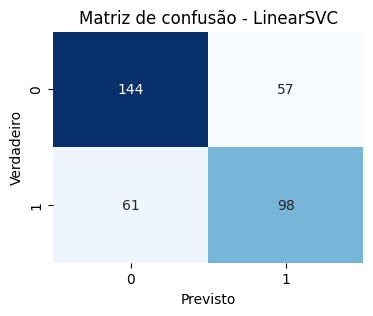



	Classifier: Logistic Regression
	Accuracy: 0.725
	Precision: 0.7
	Recall: 0.660377358490566
	F1-score: 0.6796116504854369


c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


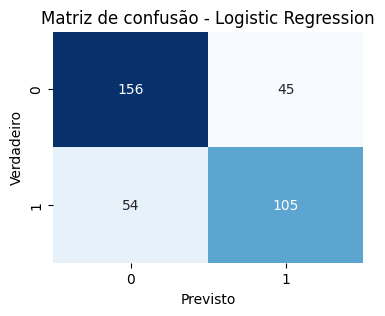



	Classifier: Random Forest
	Accuracy: 0.7194444444444444
	Precision: 0.7230769230769231
	Recall: 0.5911949685534591
	F1-score: 0.6505190311418685


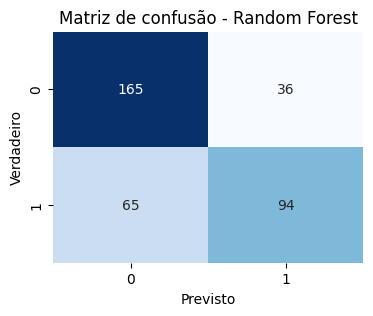



	Classifier: K-Nearest Neighbors
	Accuracy: 0.6277777777777778
	Precision: 0.5912408759124088
	Recall: 0.5094339622641509
	F1-score: 0.5472972972972973


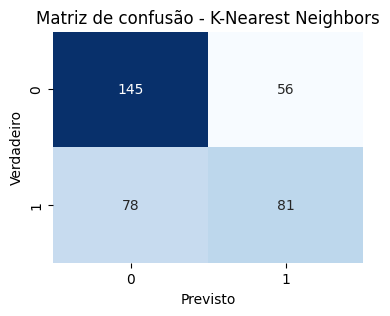



	Classifier: Gradient Boosting
	Accuracy: 0.7222222222222222
	Precision: 0.7092198581560284
	Recall: 0.6289308176100629
	F1-score: 0.6666666666666666


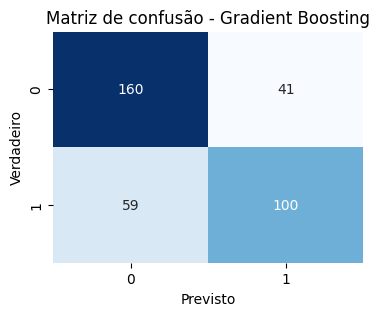



	Classifier: Decision Tree
	Accuracy: 0.625
	Precision: 0.5705882352941176
	Recall: 0.610062893081761
	F1-score: 0.5896656534954408


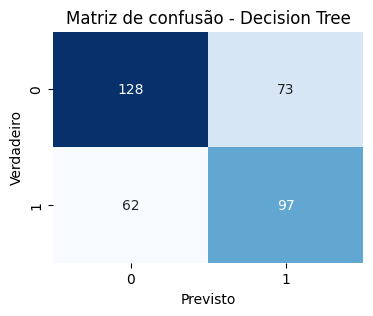



	Classifier: Gaussian Naive Bayes
	Accuracy: 0.65
	Precision: 0.6386554621848739
	Recall: 0.4779874213836478
	F1-score: 0.5467625899280576


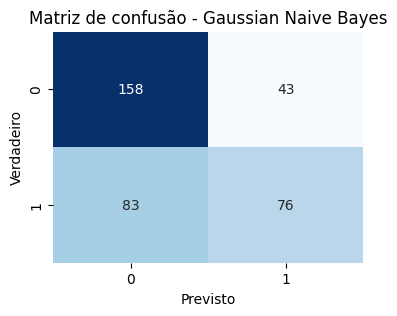

In [16]:
# Lista dos principais classificadores
classifiers = {
    'LinearSVC': LinearSVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gaussian Naive Bayes': GaussianNB()
}

# Loop sobre cada classificador
for name, clf in classifiers.items():
    # Treinar o classificador
    clf.fit(X_train, y_train)
    
    # Prever os rótulos do conjunto de teste
    y_pred = clf.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Imprimir métricas
    print(f"\tClassifier: {name}")
    print(f"\tAccuracy: {accuracy}")
    print(f"\tPrecision: {precision}")
    print(f"\tRecall: {recall}")
    print(f"\tF1-score: {f1}")
    
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de confusão - {name}')
    plt.show()
    print("\n")
    
    